# Imports

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from scipy.linalg import sqrtm
from scipy.linalg import svdvals
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.legend_handler import HandlerLine2D
import csv
import math
import re

/tmp/ipykernel_1241/418946779.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# General Functions for reading in data etc.

In [2]:
def generate_colors(n,cname):
    cmap = plt.get_cmap(cname, n+2)  # Get the YlGnBu colormap with n discrete colors
    colors = [cmap(i+1) for i in range(n)]  # Sample n colors from the colormap
    return colors

def get_subdirs(path):
    return [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

def extract_value(name: str, input_str: str):
    pattern = re.compile(rf"{name}([-+]?\d*\.?\d+)")
    match = pattern.search(input_str)
    return float(match.group(1)) if match else None

def extract_old_params(folder_names, cap = False):

    if cap:
        U_vals = [extract_value("U", fn) for fn in folder_names]
    else:
        U_vals = [extract_value("u", fn) for fn in folder_names]
    n_vals = [extract_value("n", fn) for fn in folder_names]

    beta_vals = [5] * len(folder_names)
    grain = [False] * len(folder_names)

    for idx, name in enumerate(folder_names):
        try:
            val = extract_value("beta", name)
            if val is not None:
                beta_vals[idx] = val
            #else:
            #print(f"[WARN] No beta in folder name: {name}")
        except Exception:
            print(f"[WARN] Error parsing beta in folder name: {name}")

        grain[idx] = "grain1" in name

    return U_vals, n_vals, beta_vals, grain

# Functions to compute entanglement measures and deal with density matrix

In [3]:

def get_rhoA(rhoAB):

    rhoA = np.real(np.array([
    [rhoAB[0,0] + rhoAB[1,1] + rhoAB[2,2] + rhoAB[5,5], 0, 0, 0],
    [0, rhoAB[3,3] + rhoAB[6,6] + rhoAB[8,8] + rhoAB[11,11], 0, 0],
    [0, 0, rhoAB[4,4] + rhoAB[7,7] + rhoAB[9,9] + rhoAB[12,12], 0],
    [0, 0, 0, rhoAB[10,10] + rhoAB[13,13] + rhoAB[14,14] + rhoAB[15,15]]
    ]))

    return rhoA

def get_rhoTB(rhoAB):

    rhoABTb = np.real(np.array([
    [rhoAB[0,0], 0, 0, 0, 0, 0, rhoAB[1,3], 0, 0, rhoAB[2,4], 0, 0, 0, 0, 0, rhoAB[10,5]],
    [0, rhoAB[1,1], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[7,5], 0, 0, 0],
    [0, 0, rhoAB[2,2], 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[8,5], 0, 0, 0, 0],
    [0, 0, 0, rhoAB[3,3], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[8,10], 0],
    [0, 0, 0, 0, rhoAB[4,4], 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[7,10], 0, 0],
    [0, 0, 0, 0, 0, rhoAB[5,5], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [rhoAB[1,3], 0, 0, 0, 0, 0, rhoAB[6,6], 0, 0, rhoAB[7,8], 0, 0, 0, 0, 0, rhoAB[11,13]],
    [0, 0, 0, 0, 0, 0, 0, rhoAB[7,7], 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, rhoAB[8,8], 0, 0, 0, 0, 0, 0, 0],
    [rhoAB[2,4], 0, 0, 0, 0, 0, rhoAB[7,8], 0, 0, rhoAB[9,9], 0, 0, 0, 0, 0, rhoAB[12,14]],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[10,10], 0, 0, 0, 0, 0],
    [0, 0, rhoAB[8,5], 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[11,11], 0, 0, 0, 0],
    [0, rhoAB[7,5], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[12,12], 0, 0, 0],
    [0, 0, 0, 0, rhoAB[7,10], 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[13,13], 0, 0],
    [0, 0, 0, rhoAB[8,10], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[14,14], 0],
    [rhoAB[10,5], 0, 0, 0, 0, 0, rhoAB[11,13], 0, 0, rhoAB[12,14], 0, 0, 0, 0, 0, rhoAB[15,15]]
    ]))

    return rhoABTb

def get_rhoFTB(rhoAB):

    rhoABTb = np.array([
    [rhoAB[0,0], 0, 0, 0, 0, 0, 1j*rhoAB[1,3], 0, 0, 1j*rhoAB[2,4], 0, 0, 0, 0, 0, rhoAB[10,5]],
    [0, rhoAB[1,1], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1j*rhoAB[7,5], 0, 0, 0],
    [0, 0, rhoAB[2,2], 0, 0, 0, 0, 0, 0, 0, 0, 1j*rhoAB[8,5], 0, 0, 0, 0],
    [0, 0, 0, rhoAB[3,3], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1j*rhoAB[8,10], 0],
    [0, 0, 0, 0, rhoAB[4,4], 0, 0, 0, 0, 0, 0, 0, 0, 1j*rhoAB[7,10], 0, 0],
    [0, 0, 0, 0, 0, rhoAB[5,5], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1j*rhoAB[1,3], 0, 0, 0, 0, 0, rhoAB[6,6], 0, 0, rhoAB[7,8], 0, 0, 0, 0, 0, 1j*rhoAB[11,13]],
    [0, 0, 0, 0, 0, 0, 0, rhoAB[7,7], 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, rhoAB[8,8], 0, 0, 0, 0, 0, 0, 0],
    [1j*rhoAB[2,4], 0, 0, 0, 0, 0, rhoAB[7,8], 0, 0, rhoAB[9,9], 0, 0, 0, 0, 0, 1j*rhoAB[12,14]],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[10,10], 0, 0, 0, 0, 0],
    [0, 0, 1j*rhoAB[8,5], 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[11,11], 0, 0, 0, 0],
    [0, 1j*rhoAB[7,5], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[12,12], 0, 0, 0],
    [0, 0, 0, 0, 1j*rhoAB[7,10], 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[13,13], 0, 0],
    [0, 0, 0, 1j*rhoAB[8,10], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[14,14], 0],
    [rhoAB[10,5], 0, 0, 0, 0, 0, 1j*rhoAB[11,13], 0, 0, 1j*rhoAB[12,14], 0, 0, 0, 0, 0, rhoAB[15,15]]
    ], dtype=complex)

    return rhoABTb

def get_rhoFTB_twisted(rhoAB):

    rhoABTb = np.array([
    [rhoAB[0,0], 0, 0, 0, 0, 0, -1j*rhoAB[1,3], 0, 0, -1j*rhoAB[2,4], 0, 0, 0, 0, 0, rhoAB[5,10]],
    [0, -rhoAB[1,1], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1j*rhoAB[5,7], 0, 0, 0],
    [0, 0, -rhoAB[2,2], 0, 0, 0, 0, 0, 0, 0, 0, 1j*rhoAB[5,8], 0, 0, 0, 0],
    [0, 0, 0, rhoAB[3,3], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1j*rhoAB[8,10], 0],
    [0, 0, 0, 0, rhoAB[4,4], 0, 0, 0, 0, 0, 0, 0, 0, -1j*rhoAB[7,10], 0, 0],
    [0, 0, 0, 0, 0, rhoAB[5,5], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1j*rhoAB[1,3], 0, 0, 0, 0, 0, -rhoAB[6,6], 0, 0, -rhoAB[7,8], 0, 0, 0, 0, 0, 1j*rhoAB[11,13]],
    [0, 0, 0, 0, 0, 0, 0, -rhoAB[7,7], 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, -rhoAB[8,8], 0, 0, 0, 0, 0, 0, 0],
    [1j*rhoAB[2,4], 0, 0, 0, 0, 0, -rhoAB[7,8], 0, 0, -rhoAB[9,9], 0, 0, 0, 0, 0, 1j*rhoAB[12,14]],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[10,10], 0, 0, 0, 0, 0],
    [0, 0, -1j*rhoAB[8,5], 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[11,11], 0, 0, 0, 0],
    [0, -1j*rhoAB[7,5], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[12,12], 0, 0, 0],
    [0, 0, 0, 0, 1j*rhoAB[7,10], 0, 0, 0, 0, 0, 0, 0, 0, -rhoAB[13,13], 0, 0],
    [0, 0, 0, 1j*rhoAB[8,10], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -rhoAB[14,14], 0],
    [rhoAB[10,5], 0, 0, 0, 0, 0, -1j*rhoAB[11,13], 0, 0, -1j*rhoAB[12,14], 0, 0, 0, 0, 0, rhoAB[15,15]]
    ], dtype=complex)

    return rhoABTb

def get_rhoPN(rhoAB):

    rhoABPN = np.real(np.array([
    [rhoAB[0,0], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, rhoAB[1,1], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, rhoAB[2,2], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, rhoAB[3,3], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, rhoAB[4,4], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, rhoAB[5,5], 0, 0, 0, 0, rhoAB[10,5], 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, rhoAB[6,6], 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, rhoAB[7,7], rhoAB[7,8], 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, rhoAB[7,8], rhoAB[8,8], 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[9,9], 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, rhoAB[10,5], 0, 0, 0, 0, rhoAB[10,10], 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[11,11], 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[12,12], 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[13,13], 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[14,14], 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[15,15]]
    ]))

    return rhoABPN

def get_rhoP(rhoAB):

    rhoABPN = np.real(np.array([
    [rhoAB[0,0], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, rhoAB[1,1], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, rhoAB[2,2], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, rhoAB[3,3], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, rhoAB[4,4], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, rhoAB[5,5], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, rhoAB[6,6], 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, rhoAB[7,7], rhoAB[7,8], 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, rhoAB[7,8], rhoAB[8,8], 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[9,9], 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[10,10], 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[11,11], 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[12,12], 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[13,13], 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[14,14], 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, rhoAB[15,15]]
    ]))

    return rhoABPN


def calc_I(rho):

    rhoA = get_rhoA(rho)

    eigs_rhoA = np.linalg.eigvals(rhoA) 
    eigs_rho = np.linalg.eigvals(rho)
    cutoff = 1e-12

    termA = sum(x * np.log(x) if x > cutoff else 0 for x in eigs_rhoA)
    termB = sum(x * np.log(x) if x > cutoff else 0 for x in eigs_rho)

    I = -2 * termA + termB

    return I

def calc_IR(rho):

    rhoA = get_rhoA(rho)

    IR = -2 * np.log(np.trace(rhoA @ rhoA)) + np.log(np.trace(rho @ rho))
    
    return IR

def calc_N(rho):

    rhoTNB = get_rhoTB(rho)
    N = calc_neg(rhoTNB)

    assert abs(N.imag) < 1e-10, f"Imaginary part too large: {N.imag}"
    
    return N.real

def calc_N_old(rho, twisted = False):

    if twisted:
        rhoTNB = get_rhoFTB_twisted(rho)   
    else:
        rhoTNB = get_rhoTB(rho)

    assert np.all(rhoTNB == np.conj(rhoTNB.T)), "rho not hermitian"

    N = calc_neg_old(rhoTNB)

    assert abs(N.imag) < 1e-10, f"Imaginary part too large: {N.imag}"
    
    return N.real

def calc_N_fixed(rho, twisted = False):

    if twisted:
        rhoTNB = get_rhoFTB_twisted(rho)   
    else:
        rhoTNB = get_rhoTB(rho)

    assert np.all(rhoTNB == np.conj(rhoTNB.T)), "rho not hermitian"

    N = calc_neg_old(rhoTNB) -1/2 + np.trace(rhoTNB)/2

    assert abs(N.imag) < 1e-10, f"Imaginary part too large: {N.imag}"
    
    return N.real

def calc_NF(rho, twisted = False):

    if twisted:
        rhoTNB = get_rhoFTB_twisted(rho)
    else:
        rhoTNB = get_rhoFTB(rho)
    NF = calc_neg(rhoTNB)
    
    return NF

def calc_neg(rho):

    #N = np.real( np.trace( sqrtm(np.conjugate(rho.T) @ rho) ) - 1) / 2
    N = np.real(np.sum(svdvals(rho)) - 1) / 2

    return N

def calc_neg_old(rho):

    eig = np.linalg.eigvals(rho)
    N = 0
    for i in eig:
        if i <= 0:
            N += -i
    return N

# Comparison of twisted negativity with fermionic negativity

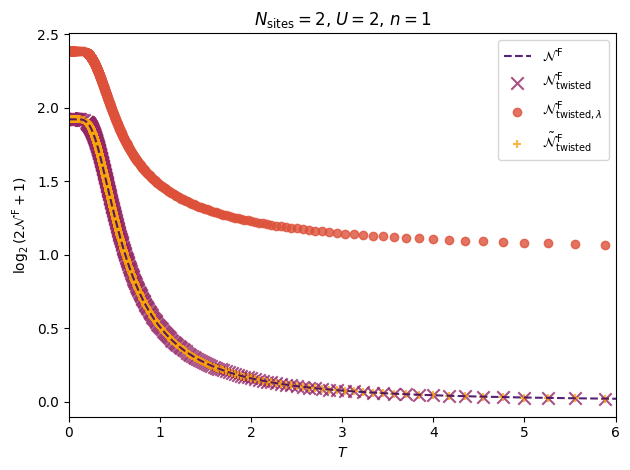

In [4]:
fig, ax = plt.subplots(1)

dirs_vec = ["./U>0/rho_ED_2ring/"]
sizees = [2]

indices = [0]

colors = generate_colors(len(indices)+3,"inferno")


idir = 0

for ids,path in enumerate(dirs_vec):

    if ids in indices:
        dirs = get_subdirs(path)
        U_vals, n_vals, beta_vals, grain = extract_old_params(dirs)

        NF = np.array([])
        NSSR = np.array([])
        PSSR = np.array([])

        NF_t = np.array([])
        NSSR_t = np.array([])
        PSSR_t = np.array([])

        for (i,direcrt) in enumerate(dirs):
            df = pd.read_csv(path+direcrt+"/rho_(1, 0).csv")

            rho = df.to_numpy()
            nf = math.log2(2*calc_NF(rho)+1)
            nssr = math.log2(2*calc_NF(get_rhoPN(rho))+1)
            pssr = math.log2(2*calc_NF(get_rhoP(rho))+1)

            threshold = 1e-12
            nf = None if nf < threshold else nf
            nssr = None if nssr < threshold else nssr
            pssr = None if pssr < threshold else pssr

            NF = np.append(NF,nf)
            NSSR = np.append(NSSR,nssr)
            PSSR = np.append(PSSR,pssr)

            
            #twisted
            nf = math.log2(2*calc_NF(rho, True)+1)
            nssr = math.log2(2*calc_N_old(rho,True)+1)
            pssr = math.log2(2*calc_N_fixed(rho,True)+1)

            threshold = 1e-12
            nf = None if nf < threshold else nf
            nssr = None if nssr < threshold else nssr
            pssr = None if pssr < threshold else pssr

            NF_t = np.append(NF_t,nf)
            NSSR_t = np.append(NSSR_t,nssr)
            PSSR_t = np.append(PSSR_t,pssr)

        NF = [x for _,x in sorted(zip(beta_vals, NF))]
        NSSR = [x for _,x in sorted(zip(beta_vals, NSSR))]
        PSSR = [x for _,x in sorted(zip(beta_vals, PSSR))]

        NF_t = [x for _,x in sorted(zip(beta_vals, NF_t))]
        NSSR_t = [x for _,x in sorted(zip(beta_vals, NSSR_t))]
        PSSR_t = [x for _,x in sorted(zip(beta_vals, PSSR_t))]
        beta_vals = np.sort(beta_vals)

        #ax.scatter([1/i for i in beta_vals], N_old, label = r"N_old")
        T = [1/i for i in beta_vals]
        al = 0.9

        ax.plot(T, NF, label = r"$\mathcal{N}^\mathrm{\,F}$", linestyle = "--", color = colors[0], alpha = al)
        ax.scatter(T, NF_t, label = r"$\mathcal{N}^\mathrm{\,F}_{\mathrm{twisted}}$", color = colors[1], alpha = al-0.1, marker = "x", s = 80)
        ax.scatter(T, NSSR_t, label = r"$\mathcal{N}^\mathrm{\,F}_{\mathrm{twisted},\lambda}$", color = colors[2], alpha = al-0.1)
        ax.scatter(T, PSSR_t, label = r"$\tilde \mathcal{N}^\mathrm{\,F}_{\mathrm{twisted}}$", color = colors[3], alpha = al-0.1, marker = "+")
        
        idir += 1

#ax.set_xscale('log')
#ax.set_yscale('log')

ax.set_xlim((0,6))
#ax.set_ylim((0,1.5))

ax.set_title(r"$N_{\mathrm{sites}}=2$, $U=2$, $n=1$")
ax.set_xlabel(r"$T$")
ax.set_ylabel(r"$\log_2\left(2\mathcal{N}^\mathrm{\,F}+1\right)$")

ax.legend()
fig.tight_layout()

fig.savefig("pic/Measure_comparison.pdf")


# Rings 

Created 6 small subplots.


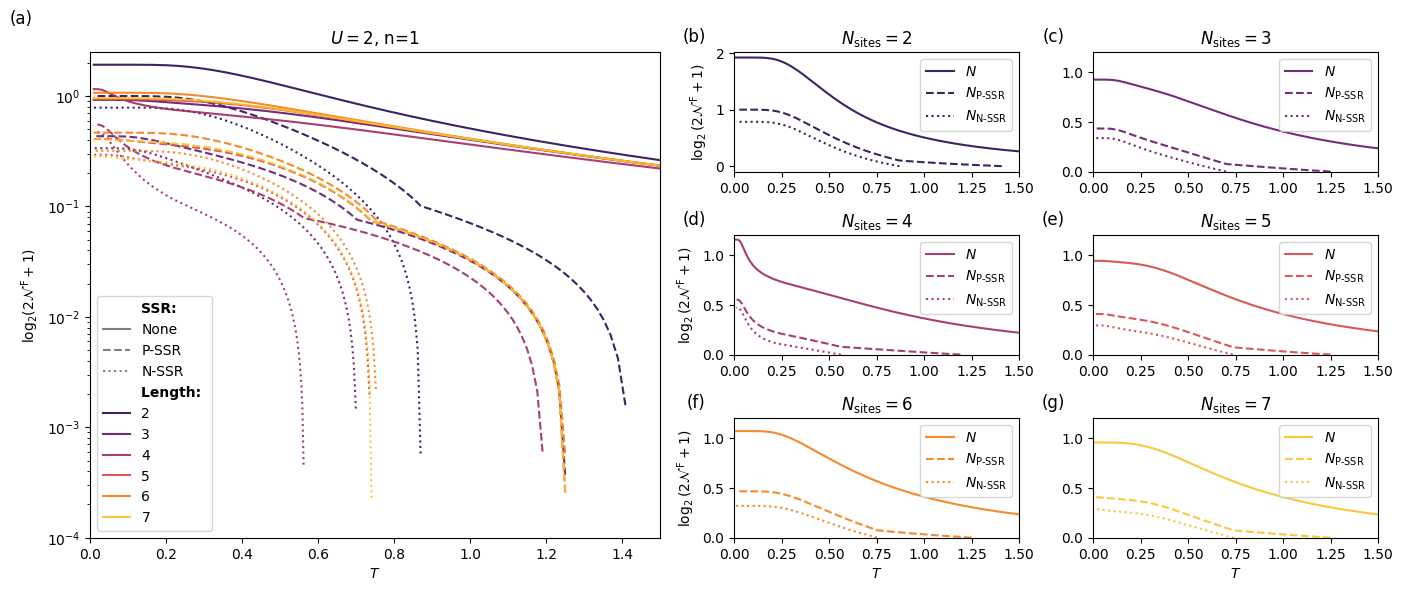

In [5]:
dirs_vec = ["./U>0/rho_ED_2ring/","./U>0/rho_ED_3ring/",
"./U>0/rho_ED_4ring/","./U>0/rho_ED_5ring/",
"./U>0/rho_ED_6ring/","./U>0/rho_ED_7ring/",
"./U>0/rho_ED_8ring/"]
sizees = [2,3,4,5,6,7,8]

indices = [0,1,2,3,4,5]

colors = generate_colors(len(indices),"inferno")



fig = plt.figure(figsize=(14, 6))
"""
gs = gridspec.GridSpec(2, 4, width_ratios=[2, 1, 1, 1])  # 2 rows, 4 columns

# main plot spans both rows of first column
ax_main = fig.add_subplot(gs[:, 0])

# create 2x3 grid of smaller subplots on the right (3 cols, 2 rows)
sub_axes = [
    fig.add_subplot(gs[i, j+1])
    for i in range(2)
    for j in range(3)
]
nrows, ncols = 2, 3
"""
# total grid: 3 rows × 3 columns (1 wide left column + 2 right columns)
gs = gridspec.GridSpec(3, 3, width_ratios=[2, 1, 1])

# main plot spans all 3 rows in the first column
ax_main = fig.add_subplot(gs[:, 0])

# 3×2 subplots (rows 0–2, cols 1–2)
sub_axes = [
    fig.add_subplot(gs[i, j + 1])
    for i in range(3)
    for j in range(2)
]
nrows, ncols = 3, 2

# check number of available small subplots
print(f"Created {len(sub_axes)} small subplots.")

idir = 0

labels = [r"(a)", r"(b)", r"(c)", r"(d)", r"(e)", r"(f)", r"(g)"]

ax_main.text(
    -0.1, 1.05, labels[0],
    transform=ax_main.transAxes,
    fontsize=12,
    #fontweight="bold",
    va="bottom",
    ha="right"
)

for ids, path in enumerate(dirs_vec):
    if ids in indices:
        k = 0
        dirs = get_subdirs(path)
        U_vals, n_vals, beta_vals, grain = extract_old_params(dirs)

        """if ids == 0:
            print(beta_vals)
        """

        NF = []
        NSSR = []
        PSSR = []

        for direcrt in dirs:
            df = pd.read_csv(path + direcrt + "/rho_(1, 0).csv")
            rho = df.to_numpy()

            nf = math.log2(2*calc_NF(rho) + 1)
            nssr = math.log2(2*calc_NF(get_rhoPN(rho)) + 1)
            pssr = math.log2(2*calc_NF(get_rhoP(rho)) + 1)

            threshold = 1e-16
            nf = None if nf < threshold else nf
            nssr = None if nssr < threshold else nssr
            pssr = None if pssr < threshold else pssr

            NF.append(nf)
            NSSR.append(nssr)
            PSSR.append(pssr)

            k += 1

        # sort by beta
        beta_vals, NF, NSSR, PSSR = zip(*sorted(zip(beta_vals, NF, NSSR, PSSR)))
        T = [1 / b for b in beta_vals]

        al = 0.9
        color = colors[idir]

        # === main plot ===
        """  if idir == 0:
            ax_main.plot(T, NF, label=f"$N_{\mathrm{sites}}={sizees[ids]}, N$", ls="-", c=color, alpha=al)
            ax_main.plot(T, NSSR, label=f"$N_{\mathrm{sites}}={sizees[ids]}, N_{\text{P-SSR}}$", ls="--", c=color, alpha=al)
            ax_main.plot(T, PSSR, label=f"$N_{\mathrm{sites}}={sizees[ids]}, N_{\text{N-SSR}}$", ls=":", c=color, alpha=al)
        else:
            ax_main.plot(T, NF, label=f"$N_{\mathrm{sites}}={sizees[ids]}$", ls="-", c=color, alpha=al)
            ax_main.plot(T, NSSR, ls="--", c=color, alpha=al)
            ax_main.plot(T, PSSR, ls=":", c=color, alpha=al) """
        ax_main.plot(T, NF, label=f"{sizees[ids]}", ls="-", c=color, alpha=al)
        ax_main.plot(T, NSSR, ls="--", c=color, alpha=al)
        ax_main.plot(T, PSSR, ls=":", c=color, alpha=al)

        # === subplot grid ===
        if idir < len(sub_axes):
            ax_sub = sub_axes[idir]
            ax_sub.plot(T, NF, ls="-", label=r"$N$", c=color, alpha=al)
            ax_sub.plot(T, NSSR, ls="--", label=r"$N_{\text{P-SSR}}$", c=color, alpha=al)
            ax_sub.plot(T, PSSR, ls=":", label=r"$N_{\text{N-SSR}}$", c=color, alpha=al)
            ax_sub.set_title(f"$N_{{\\mathrm{{sites}}}}={sizees[ids]}$")
            ax_sub.set_xlim((0, 1.5))
            if not (sizees[ids] == 2):
                ax_sub.set_ylim((0, 1.2))
            ax_sub.legend()

            ax_sub.text(
                    -0.1, 1.05, labels[idir + 1],
                    transform=ax_sub.transAxes,
                    fontsize=12,
                    #fontweight="bold",
                    va="bottom",
                    ha="right"
                )

            row = (idir) // ncols
            col = (idir) % ncols

            if col == 0:
                ax_sub.set_ylabel(r"$\log_2(2\mathcal{N}^\mathrm{\,F}+1)$")
            if row == nrows - 1:
                ax_sub.set_xlabel(r"$T$")

        idir += 1

handles, labels = ax_main.get_legend_handles_labels()
dummy1 = Line2D([], [], linestyle='-', color='grey')
dummy2 = Line2D([], [], linestyle='--', color='grey')
dummy3 = Line2D([], [], linestyle=':', color='grey')
dummy4 = Line2D([], [], linestyle='-', color='white', alpha = 0)
dummy5 = Line2D([], [], linestyle='-', color='white', alpha = 0)
handles.insert(0,dummy4)
handles.insert(0,dummy3)
handles.insert(0,dummy2)
handles.insert(0,dummy1)
handles.insert(0,dummy5)
labels.insert(0,"Length: ")
labels.insert(0,"N-SSR")
labels.insert(0,"P-SSR")
labels.insert(0,"None")
labels.insert(0,"SSR:")

"""
T_2 = np.linspace(0.01, 5, 500)
betas_2 = np.array([1/(i) for i in T_2]) #0.379*
values = f(1,2,betas_2)
ax_main.plot(T_2, values)

n, n_ssr, n_ssr2 = get_N_ed(1,2,betas_2)
ax_main.plot(T_2, n, marker = "x")
ax_main.plot(T_2, n_ssr, marker = ".")
ax_main.plot(T_2, n_ssr2, marker = "o")
"""

ax_main.set_yscale('log')
ax_main.set_xlim((0, 1.5))
ax_main.set_ylim((10**-4, 2.5))
ax_main.set_title(r"$U=2$, n=$1$")
ax_main.set_xlabel(r"$T$")
ax_main.set_ylabel(r"$\log_2\!\left(2\mathcal{N}^\mathrm{\,F}+1\right)$")
leg = ax_main.legend(handles, labels)
leg.get_texts()[0].set_fontweight('bold')
leg.get_texts()[4].set_fontweight('bold')

fig.tight_layout()
fig.savefig("pic/NF_rings.pdf")
plt.show()

# Clusters

Created 3 small subplots.


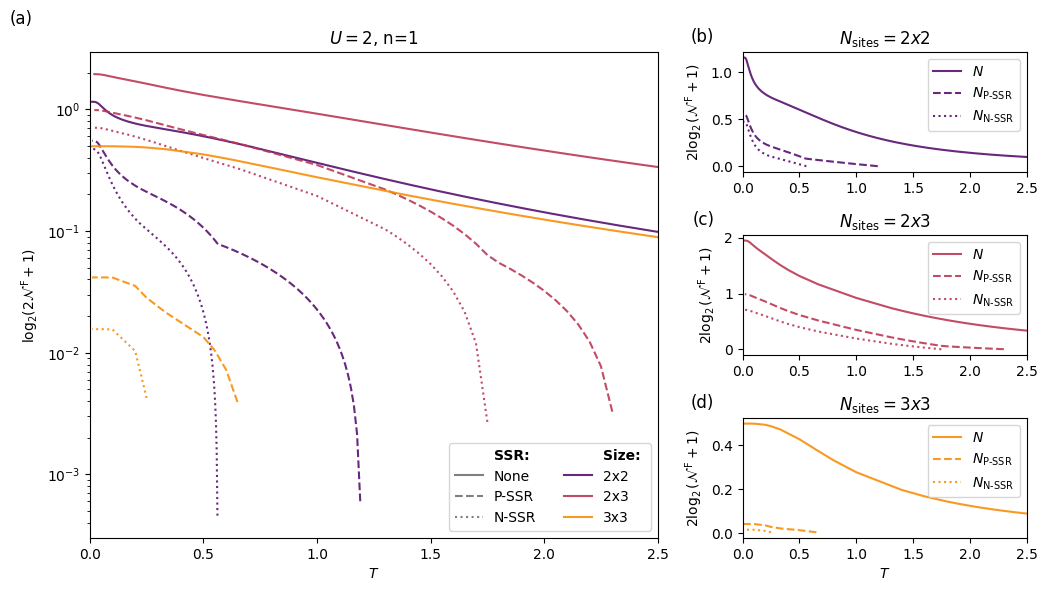

In [6]:
dirs_vec = ["./U>0/rho_ED_4ring/","./U>0/rho_ED_2x3/","./U>0/rho_ED_3x3/"]
sizees = ["2x2","2x3","3x3"]

indices = [0,1,2]

colors = generate_colors(len(indices),"inferno")



fig = plt.figure(figsize=(10.5, 6))

# total grid: 3 rows × 3 columns (1 wide left column + 2 right columns)
gs = gridspec.GridSpec(3, 2, width_ratios=[2, 1])

# main plot spans all 3 rows in the first column
ax_main = fig.add_subplot(gs[:, 0])

# 3×2 subplots (rows 0–2, cols 1–2)
sub_axes = [
    fig.add_subplot(gs[i, j + 1])
    for i in range(3)
    for j in range(1)
]
nrows, ncols = 3, 1

# check number of available small subplots
print(f"Created {len(sub_axes)} small subplots.")

idir = 0

labels = [r"(a)", r"(b)", r"(c)", r"(d)", r"(e)", r"(f)", r"(g)"]

ax_main.text(
    -0.1, 1.05, labels[0],
    transform=ax_main.transAxes,
    fontsize=12,
    #fontweight="bold",
    va="bottom",
    ha="right"
)

for ids, path in enumerate(dirs_vec):
    if ids in indices:
        dirs = get_subdirs(path)
        U_vals, n_vals, beta_vals, grain = extract_old_params(dirs)

        NF = []
        NSSR = []
        PSSR = []

        for direcrt in dirs:
            df = pd.read_csv(path + direcrt + "/rho_(1, 0).csv")
            rho = df.to_numpy()

            nf = math.log2(2*calc_NF(rho) + 1)
            nssr = math.log2(2*calc_NF(get_rhoPN(rho)) + 1)
            pssr = math.log2(2*calc_NF(get_rhoP(rho)) + 1)

            threshold = 1e-12
            nf = None if nf < threshold else nf
            nssr = None if nssr < threshold else nssr
            pssr = None if pssr < threshold else pssr

            NF.append(nf)
            NSSR.append(nssr)
            PSSR.append(pssr)

        # sort by beta
        beta_vals, NF, NSSR, PSSR = zip(*sorted(zip(beta_vals, NF, NSSR, PSSR)))
        T = [1 / b for b in beta_vals]

        al = 0.9
        color = colors[idir]

        # === main plot ===
        ax_main.plot(T, NF, label=f"{sizees[ids]}", ls="-", c=color, alpha=al)
        ax_main.plot(T, NSSR, ls="--", c=color, alpha=al)
        ax_main.plot(T, PSSR, ls=":", c=color, alpha=al)

        # === subplot grid ===
        if idir < len(sub_axes):
            ax_sub = sub_axes[idir]
            ax_sub.plot(T, NF, ls="-", label=r"$N$", c=color, alpha=al)
            ax_sub.plot(T, NSSR, ls="--", label=r"$N_{\text{P-SSR}}$", c=color, alpha=al)
            ax_sub.plot(T, PSSR, ls=":", label=r"$N_{\text{N-SSR}}$", c=color, alpha=al)
            ax_sub.set_title(f"$N_{{\\mathrm{{sites}}}}={sizees[ids]}$")
            ax_sub.set_xlim((0, 2.5))
            ax_sub.legend()

            ax_sub.text(
                    -0.1, 1.05, labels[idir + 1],
                    transform=ax_sub.transAxes,
                    fontsize=12,
                    #fontweight="bold",
                    va="bottom",
                    ha="right"
                )

            row = (idir) // ncols
            col = (idir) % ncols

            if col == 0:
                ax_sub.set_ylabel(r"$2\log_2(\mathcal{N}^\mathrm{\,F}+1)$")
            if row == nrows - 1:
                ax_sub.set_xlabel(r"$T$")

        idir += 1

handles, labels = ax_main.get_legend_handles_labels()
dummy1 = Line2D([], [], linestyle='-', color='grey')
dummy2 = Line2D([], [], linestyle='--', color='grey')
dummy3 = Line2D([], [], linestyle=':', color='grey')
dummy4 = Line2D([], [], linestyle='-', color='white', alpha = 0)
dummy5 = Line2D([], [], linestyle='-', color='white', alpha = 0)
handles.insert(0,dummy4)
handles.insert(0,dummy3)
handles.insert(0,dummy2)
handles.insert(0,dummy1)
handles.insert(0,dummy5)
labels.insert(0,"Size: ")
labels.insert(0,"N-SSR")
labels.insert(0,"P-SSR")
labels.insert(0,"None")
labels.insert(0,"SSR:")

ax_main.set_yscale('log')
ax_main.set_xlim((0, 2.5))
#ax_main.set_ylim((0, 1.5))
ax_main.set_title(r"$U=2$, n=$1$")
ax_main.set_xlabel(r"$T$")
ax_main.set_ylabel(r"$\log_2\!\left(2\mathcal{N}^\mathrm{\,F}+1\right)$")
leg = ax_main.legend(handles, labels, ncol=2)
leg.get_texts()[0].set_fontweight('bold')
leg.get_texts()[4].set_fontweight('bold')

fig.tight_layout()
fig.savefig("pic/NF_clusters.pdf")
plt.show()

# Nagaoka Ferromagnetism

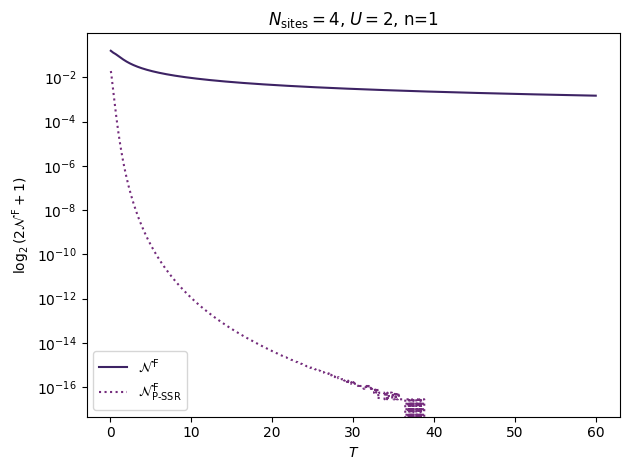

In [7]:
fig, ax = plt.subplots(1)

#colors = ["darkred", "goldenrod", "yellowgreen", "mediumblue", "lightcoral", "orange", "seagreen", "cornflowerblue" ]
colors = generate_colors(len(indices)+3,"inferno")

data_fnn  = np.loadtxt("./Nagaoka/NF.csv", delimiter=",")
data_fnnn = np.loadtxt("./Nagaoka/N.csv", delimiter=",")

x_fnn, fnn_vals   = data_fnn[:,0],  data_fnn[:,1]
x_fnnn, fnnn_vals = data_fnnn[:,0], data_fnnn[:,1]

al = 0.9

ax.plot(x_fnn, fnn_vals, label = r"$\mathcal{N}^\mathrm{\,F}$", linestyle = "-", color = colors[0], alpha = al)
ax.plot(x_fnnn, fnnn_vals, label = r"$\mathcal{N}^\mathrm{\,F}_{\text{P-SSR}}$", linestyle = ":", color = colors[1], alpha = al)

#ax.set_xscale('log')
ax.set_yscale('log')

#ax.set_xlim((0,20))
#ax.set_ylim((0,1.5))

ax.set_title(r"$N_{\mathrm{sites}}=4$, $U=2$, n=$1$")
ax.set_xlabel(r"$T$")
ax.set_ylabel(r"$\log_2\left(2\mathcal{N}^\mathrm{\,F}+1\right)$")

ax.legend()
fig.tight_layout()

fig.savefig("pic/Nagaoka.pdf")


# 1D Test

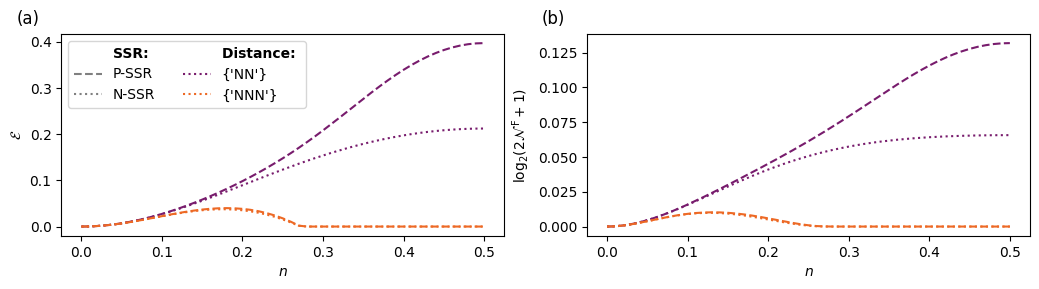

In [8]:
distances = pd.read_csv("./U=0/data/Test1D_distances.csv", header = None).iloc[0,:].tolist()
fillings = pd.read_csv("./U=0/data/Test1D_fillings.csv", header = None).iloc[:,0].tolist()

indices = [0,1]
lables = [r"NN",r"NNN"]
colors = generate_colors(len(indices),"inferno")

fig, ax = plt.subplots(1,2,figsize=(10.5, 3))

for i in indices:
    
    PPT_nSSR = pd.read_csv(f"./U=0/data/Test1D_PPTnSSR_d{i+1}.csv", header = None).iloc[:,0].tolist()
    PPT_pSSR = pd.read_csv(f"./U=0/data/Test1D_PPTpSSR_d{i+1}.csv", header = None).iloc[:,0].tolist()
    REE_nSSR = pd.read_csv(f"./U=0/data/Test1D_REEnSSR_d{i+1}.csv", header = None).iloc[:,0].tolist()
    REE_pSSR = pd.read_csv(f"./U=0/data/Test1D_REEpSSR_d{i+1}.csv", header = None).iloc[:,0].tolist()

    ax[0].plot(fillings,PPT_nSSR,linestyle=":",color=colors[i], label = {lables[i]})
    ax[0].plot(fillings,PPT_pSSR,linestyle="--",color=colors[i])

    ax[1].plot(fillings,REE_nSSR,linestyle=":",color=colors[i])
    ax[1].plot(fillings,REE_pSSR,linestyle="--",color=colors[i])

handles, labels = ax[0].get_legend_handles_labels()
dummy2 = Line2D([], [], linestyle='--', color='grey')
dummy3 = Line2D([], [], linestyle=':', color='grey')
dummy4 = Line2D([], [], linestyle='-', color='white', alpha = 0)
dummy5 = Line2D([], [], linestyle='-', color='white', alpha = 0)
handles.insert(0,dummy4)
handles.insert(0,dummy3)
handles.insert(0,dummy2)
handles.insert(0,dummy5)
labels.insert(0,"Distance: ")
labels.insert(0,"N-SSR")
labels.insert(0,"P-SSR")
labels.insert(0,"SSR:")

ax[0].set_xlabel(r"$n$")
ax[1].set_xlabel(r"$n$")
ax[1].set_ylabel(r"$\log_2\!\left(2\mathcal{N}^\mathrm{\,F}+1\right)$")
ax[0].set_ylabel(r"$\mathcal{E}$")
leg = ax[0].legend(handles, labels, ncol=2)
leg.get_texts()[0].set_fontweight('bold')
leg.get_texts()[3].set_fontweight('bold')

labels = [r"(a)", r"(b)", r"(c)", r"(d)", r"(e)", r"(f)", r"(g)"]
ax[0].text(
    -0.05, 1.03, labels[0],
    transform=ax[0].transAxes,
    fontsize=12,
    #fontweight="bold",
    va="bottom",
    ha="right"
)
ax[1].text(
    -0.05, 1.03, labels[1],
    transform=ax[1].transAxes,
    fontsize=12,
    #fontweight="bold",
    va="bottom",
    ha="right"
)

fig.tight_layout()
fig.savefig("pic/1D_GroundState_noninteracting_new.pdf")
    

# 1D Thermal 

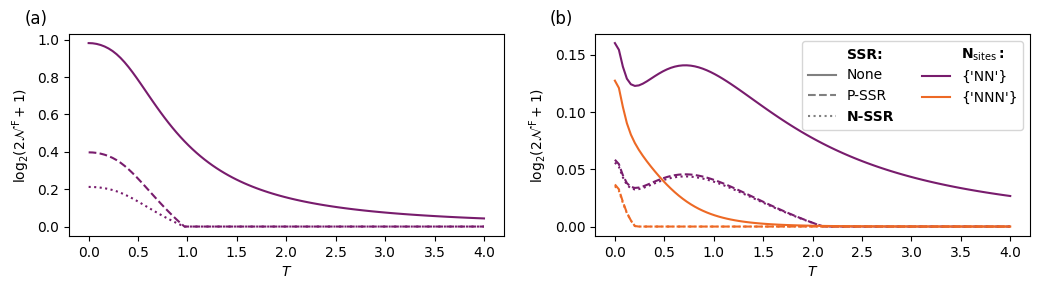

In [9]:
distances = pd.read_csv("./U=0/data/Thermal1D_distances.csv", header = None).iloc[0,:].tolist()
fillings = pd.read_csv("./U=0/data/Thermal1D_fillings.csv", header = None).iloc[:,0].tolist()
temp = pd.read_csv("./U=0/data/Thermal1D_temperatures.csv", header = None).iloc[0,:].tolist()

indices = [0,1]
lables = [r"NN",r"NNN"]
colors = generate_colors(len(indices),"inferno")

fig, ax = plt.subplots(1,2,figsize=(10.5, 3))

for fi in range(2):
    if fillings[fi] == 0.5:
        indices = [0]
    else:
        indices = [0,1]
        
    for i in indices:
        PPT_full = pd.read_csv(f"./U=0/data/Thermal1D_PPTfull_d{i+1}_f{fillings[fi]}.csv", header = None).iloc[0,:].tolist()
        PPT_nSSR = pd.read_csv(f"./U=0/data/Thermal1D_PPTnSSR_d{i+1}_f{fillings[fi]}.csv", header = None).iloc[0,:].tolist()
        PPT_pSSR = pd.read_csv(f"./U=0/data/Thermal1D_PPTpSSR_d{i+1}_f{fillings[fi]}.csv", header = None).iloc[0,:].tolist()

        ax[fi].plot(temp,PPT_full,linestyle="-",color=colors[i], label = {lables[i]})
        ax[fi].plot(temp,PPT_nSSR,linestyle=":",color=colors[i])
        ax[fi].plot(temp,PPT_pSSR,linestyle="--",color=colors[i])

handles, labels = ax[1].get_legend_handles_labels()
dummy1 = Line2D([], [], linestyle='-', color='grey')
dummy2 = Line2D([], [], linestyle='--', color='grey')
dummy3 = Line2D([], [], linestyle=':', color='grey')
dummy4 = Line2D([], [], linestyle='-', color='white', alpha = 0)
dummy5 = Line2D([], [], linestyle='-', color='white', alpha = 0)
handles.insert(0,dummy4)
handles.insert(0,dummy3)
handles.insert(0,dummy2)
handles.insert(0,dummy1)
handles.insert(0,dummy5)
labels.insert(0,"$\mathbf{N_{\mathrm{sites}}:}$")
labels.insert(0,"N-SSR")
labels.insert(0,"P-SSR")
labels.insert(0,"None")
labels.insert(0,"SSR:")

ax[0].set_xlabel(r"$T$")
ax[1].set_xlabel(r"$T$")
ax[1].set_ylabel(r"$\log_2\!\left(2\mathcal{N}^\mathrm{\,F}+1\right)$")
ax[0].set_ylabel(r"$\log_2\!\left(2\mathcal{N}^\mathrm{\,F}+1\right)$")
leg = ax[1].legend(handles, labels, ncol=2)
leg.get_texts()[0].set_fontweight('bold')
leg.get_texts()[3].set_fontweight('bold')

labels = [r"(a)", r"(b)", r"(c)", r"(d)", r"(e)", r"(f)", r"(g)"]
ax[0].text(
    -0.05, 1.03, labels[0],
    transform=ax[0].transAxes,
    fontsize=12,
    #fontweight="bold",
    va="bottom",
    ha="right"
)
ax[1].text(
    -0.05, 1.03, labels[1],
    transform=ax[1].transAxes,
    fontsize=12,
    #fontweight="bold",
    va="bottom",
    ha="right"
)

fig.tight_layout()
fig.savefig("pic/1D_Thermal_noninteracting.pdf")
    

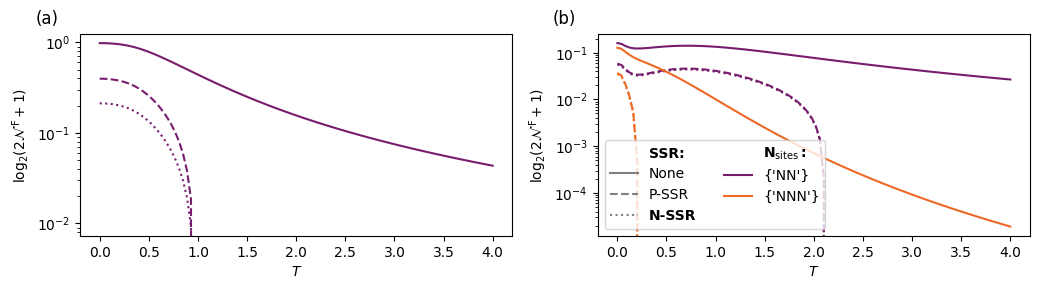

In [10]:
distances = pd.read_csv("./U=0/data/Thermal1D_distances.csv", header = None).iloc[0,:].tolist()
fillings = pd.read_csv("./U=0/data/Thermal1D_fillings.csv", header = None).iloc[:,0].tolist()
temp = pd.read_csv("./U=0/data/Thermal1D_temperatures.csv", header = None).iloc[0,:].tolist()

indices = [0,1]
lables = [r"NN",r"NNN"]
colors = generate_colors(len(indices),"inferno")

fig, ax = plt.subplots(1,2,figsize=(10.5, 3))

for fi in range(2):
    if fillings[fi] == 0.5:
        indices = [0]
    else:
        indices = [0,1]
        
    for i in indices:
        PPT_full = pd.read_csv(f"./U=0/data/Thermal1D_PPTfull_d{i+1}_f{fillings[fi]}.csv", header = None).iloc[0,:].tolist()
        PPT_nSSR = pd.read_csv(f"./U=0/data/Thermal1D_PPTnSSR_d{i+1}_f{fillings[fi]}.csv", header = None).iloc[0,:].tolist()
        PPT_pSSR = pd.read_csv(f"./U=0/data/Thermal1D_PPTpSSR_d{i+1}_f{fillings[fi]}.csv", header = None).iloc[0,:].tolist()

        ax[fi].plot(temp,PPT_full,linestyle="-",color=colors[i], label = {lables[i]})
        ax[fi].plot(temp,PPT_nSSR,linestyle=":",color=colors[i])
        ax[fi].plot(temp,PPT_pSSR,linestyle="--",color=colors[i])

handles, labels = ax[1].get_legend_handles_labels()
dummy1 = Line2D([], [], linestyle='-', color='grey')
dummy2 = Line2D([], [], linestyle='--', color='grey')
dummy3 = Line2D([], [], linestyle=':', color='grey')
dummy4 = Line2D([], [], linestyle='-', color='white', alpha = 0)
dummy5 = Line2D([], [], linestyle='-', color='white', alpha = 0)
handles.insert(0,dummy4)
handles.insert(0,dummy3)
handles.insert(0,dummy2)
handles.insert(0,dummy1)
handles.insert(0,dummy5)
labels.insert(0,"$\mathbf{N_{\mathrm{sites}}:}$")
labels.insert(0,"N-SSR")
labels.insert(0,"P-SSR")
labels.insert(0,"None")
labels.insert(0,"SSR:")

ax[0].set_xlabel(r"$T$")
ax[1].set_xlabel(r"$T$")
ax[1].set_ylabel(r"$\log_2\!\left(2\mathcal{N}^\mathrm{\,F}+1\right)$")
ax[0].set_ylabel(r"$\log_2\!\left(2\mathcal{N}^\mathrm{\,F}+1\right)$")
leg = ax[1].legend(handles, labels, ncol=2)
leg.get_texts()[0].set_fontweight('bold')
leg.get_texts()[3].set_fontweight('bold')

labels = [r"(a)", r"(b)", r"(c)", r"(d)", r"(e)", r"(f)", r"(g)"]
ax[0].text(
    -0.05, 1.03, labels[0],
    transform=ax[0].transAxes,
    fontsize=12,
    #fontweight="bold",
    va="bottom",
    ha="right"
)
ax[1].text(
    -0.05, 1.03, labels[1],
    transform=ax[1].transAxes,
    fontsize=12,
    #fontweight="bold",
    va="bottom",
    ha="right"
)

ax[0].set_yscale('log')
ax[1].set_yscale('log')

fig.tight_layout()
fig.savefig("pic/1D_Thermal_noninteracting_log.pdf")
    